In [105]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [106]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputAlgorithmsFolder = inputFolder + r"\algorithms"

outputAllFolder = outputFolder + r"\all"
outputSummaryFolder = outputFolder + r"\summary"
outputTechniquesFolder = outputFolder + r"\techniques"

dataVisualizationTopLimit = 20

testSize = 0.2
randomState = 0
samplingStrategy = 0.2
percentileNumberStd = 90
percentileNumberCorrelation = 90
partitionsNumber = int(1/testSize) #Para el kfold, es 1 sobre el test size (para que hagan match)

In [107]:
classifiers = {
  "K vecinos más cercanos": { "name": "K vecinos más cercanos", "acronym": "KNN", "classifier": KNeighborsClassifier(n_neighbors=1, n_jobs=-1) }, 
  "Máquina de vectores de soporte": { "name": "Máquina de vectores de soporte", "acronym": "SVM", "classifier": SVC(random_state=randomState, kernel='poly') }, 
  "Regresión logística": { "name": "Regresión logística", "acronym": "LR", "classifier": LogisticRegression(random_state=randomState, max_iter=200) }, 
  "Naive bayes gaussiano": { "name": "Naive bayes gaussiano", "acronym": "GNB", "classifier": GaussianNB() }, 
  "Aumento de gradiente": { "name": "Aumento de gradiente", "acronym": "GBM", "classifier": GradientBoostingClassifier(random_state=randomState) }, 
  "Árbol de decisión": { "name": "Árbol de decisión", "acronym": "DT", "classifier": DecisionTreeClassifier(random_state=randomState) }, 
  "Bosque aleatorio": { "name": "Bosque aleatorio", "acronym": "RF", "classifier": RandomForestClassifier(random_state=randomState) }, 
}

In [108]:
crossValidators = {
  "K pliegues": { "name": "K pliegues", "acronym": "KP", "validator": KFold(n_splits=partitionsNumber, shuffle=True, random_state=randomState) }, 
  "K pliegues estratificados": { "name": "K pliegues estratificados", "acronym": "KPE", "validator": StratifiedKFold(n_splits=partitionsNumber, shuffle=True, random_state=randomState) }, 
  "División aleatoria": { "name": "División aleatoria", "acronym": "DA", "validator": ShuffleSplit(n_splits=partitionsNumber, test_size=testSize, random_state=randomState) }, 
  "División aleatoria estratificada": { "name": "División aleatoria estratificada", "acronym": "DAE", "validator": StratifiedShuffleSplit(n_splits=partitionsNumber, test_size=testSize, random_state=randomState) }, 
}

In [109]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [110]:
def preprocessingData(inputPath):
  # Leyendo datos
  df = readCsvAsDf(inputPath)

  # Balanceo de datos: Sobremuestreo aleatorio (oversampling) (1 de cada 5)
  objectiveColumn = "contratado"
  dictResults = dict(df[objectiveColumn].value_counts().sort_index())

  maxKey = max(dictResults, key=dictResults.get)
  maxValue = max(dictResults.values())

  dfClassMaxKey = df[df[objectiveColumn] == maxKey]

  for key, value in dictResults.items():
    if key != maxKey:
      dfClass = df[df[objectiveColumn] == key]
      dfClassSampled = dfClass.sample(int(maxValue * samplingStrategy), random_state=randomState, replace=True)
      dfClassMaxKey = pd.concat([dfClassMaxKey, dfClassSampled],axis=0)

  df = dfClassMaxKey

  # Aleatorizacion del orden de los registros para evitar sesgos(filas)
  df = df.sample(frac = 1, random_state=randomState).reset_index(drop=True)

  # Aplicando OrdinalEncoding a las variables categóricas ordinales()
  encoder = OrdinalEncoder(categories=[[ "Abandonado", "En Curso", "Graduado" ]])
  encoder.fit(df[["estadoUltimoEstudio"]])
  df["estadoUltimoEstudio"] = encoder.transform(df[["estadoUltimoEstudio"]])
  encoder = OrdinalEncoder(categories=[[ "Otro", "Secundario", "Terciario/Tecnico", "Universitario", "Posgrado", "Master", "Doctorado" ]])
  encoder.fit(df[["gradoUltimoEstudio"]])
  df["gradoUltimoEstudio"] = encoder.transform(df[["gradoUltimoEstudio"]])

  # Aplicando OneHotEncoding a las variables categóricas cardinales (transformación a numéricas mediante columnas)
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]
  for column in categoricalCardinalColumns:
    dummies = pd.get_dummies(df[[column]], prefix=column, dummy_na=True)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(columns=[column])

  # Aplicando MinMaxScaler a las variables numéricas (normalización) (esto tambien incluye a lastEducationStatus y lastEducationDegree, ya numéricas)
  # Algunas quedaran en 0.9999, esto porque no todas manejan la misma escala (sin decimales, o solo un decimal)
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].fillna(0.0)
  mms = MinMaxScaler()
  df[numericalColumns] = mms.fit_transform(df[numericalColumns])

  # Eliminando columnas con varianza cercana a cero, dejando el 10% de columnas con mayor varianza (variables no afectan en el resultado del modelo)
  df.loc['std'] = df.std()
  stdArray = df.iloc[len(df)-1]
  nthPercentileStd = np.percentile(stdArray, percentileNumberStd)
  df = df.transpose()
  df = df[df["std"]>nthPercentileStd]
  df = df.transpose()
  df = df.drop(['std'], axis=0)

  # Eliminando columnas con correlación cercana a uno, dejando el 90% de columnas con menor correlación
  correlationMatrix = df.corr().abs()
  correlationMatrix[correlationMatrix == 1.0] = 0.0
  maxCorrelationValues = [max(correlationMatrix[column]) for column in correlationMatrix.columns]
  nthPercentileCorrelation = np.percentile(maxCorrelationValues, percentileNumberCorrelation)
  highCorrelationColumns = [column for column in correlationMatrix.columns if max(correlationMatrix[column]) > nthPercentileCorrelation]
  df = df.drop(highCorrelationColumns, axis=1)

  writeDfToCsv(df, os.path.join(processFolder, 'result.csv'))

  return df

In [111]:
def showMetricsCharts(metricsList, context, unit):
  metrics = [
    {"exactitud": "Exactitud"},
    {"precision": "Precisión"},
    {"sensibilidad": "Sensibilidad"},
    {"robustez": "Robustez"},
    {"tiempoPromedio": "Tiempo promedio"},
    {"promedioMetricas": "Promedio de métricas"},
  ]

  for metric in metrics:
    key = list(metric.keys())[0]
    value = metric[key]

    if key != "tiempoPromedio":
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key].strip('%')) / 100
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
      
      sortedValues = sorted(values)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
      plt.ylabel("Porcentaje")
      plt.title("{} por {}".format(value, unit))
      plt.show()
    else:
      data = {}
      for elem in metricsList:
        data["\n".join(elem[context].split(" "))] = float(elem[key].strip('s'))
      
      keys = list(data.keys())
      values = list(data.values())
        
      fig = plt.figure(figsize = (10, 5))
          
      sortedValues = sorted(values, reverse=True)
      maxValue, secondMaxValue, thirdMaxValue = sortedValues[len(sortedValues)-1], sortedValues[len(sortedValues)-2], sortedValues[len(sortedValues)-3]
      colors = ['tab:red' if (elem == maxValue) else ('tab:blue' if elem == secondMaxValue else ('tab:blue' if elem == thirdMaxValue else 'tab:blue')) for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.5f}".format(x) + "s"))
      plt.ylabel("Segundos")
      plt.title("{} por {}".format(value, unit))
      plt.show()

In [112]:
def splitData(X, y):
  # Dividiendo los dataframes de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=randomState)

  return X_train, X_test, y_train, y_test

In [113]:
def trainModel(X_train, X_test, y_train, y_test, algorithm):
  # Creación del clasificador
  clf = classifiers[algorithm]["classifier"]

  # Entrenamiento del clasificador
  clf.fit(X_train, y_train)

  # Calculando la predicción del modelo con la data de prueba
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [114]:
def getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, partitionNumber, technique):
  trainRows = len(y_train)
  testRows = len(y_test)

  # Calculando la exactitud del modelo
  accuracy = accuracy_score(y_test, y_pred)

  # Calculando la precisión del modelo
  precision = precision_score(y_test, y_pred)

  # Calculando la sensibilidad del modelo
  recall = recall_score(y_test, y_pred)

  # Calculando el valor F del modelo (robustez)
  f1Score = f1_score(y_test, y_pred)

  # Calculando el promedio de métricas
  metricsList = [accuracy, precision, recall, f1Score]
  metricsMean = sum(metricsList) / len(metricsList)

  # Calculando el tiempo de ejecución del modelo
  executionTime = (endDate - startDate).total_seconds()

  # Obteniendo la matriz de confusión
  confussionMatrix = str(confusion_matrix(y_test, y_pred).tolist())
  
  return {
    "sigla": crossValidators[technique]["acronym"],
    "algoritmo": algorithm,
    "particion": "Partición {}".format(partitionNumber),
    "tecnicaValidacion": technique,
    "registrosEntrenamiento": trainRows,
    "registrosPrueba": testRows,
    "proporcionSobremuestreo": samplingStrategy,
    "matrizConfusion": confussionMatrix,
    "exactitud": "{:.2%}".format(accuracy),
    "precision": "{:.2%}".format(precision),
    "sensibilidad": "{:.2%}".format(recall),
    "robustez": "{:.2%}".format(f1Score),
    "promedioMetricas": "{:.2%}".format(metricsMean),
    "tiempoTotal": "{:.5f}".format(executionTime) + "s",
    "tiempoPromedio": "{:.5f}".format(executionTime/(trainRows + testRows)) + "s",
  }

In [115]:
def evaluation(df, algorithm):
  # Creando el arreglo de metricas de cada algoritmo
  partitionsMetricsList = []

  # Lectura de las variables de características y objetivo
  objectiveColumn = "contratado"
  X = df.drop([objectiveColumn], axis=1)
  y = df[objectiveColumn]

  # Iterando por cada validacion cruzada
  for key, value in crossValidators.items():
    for index, (train_index, test_index) in enumerate(value["validator"].split(X, y)):
      X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index, :], y.iloc[train_index], y.iloc[test_index]

      # Mostrando que partición se usa
      print("Ejecutando para: Técnica {} - Partición {}".format(key, str(index+1)))

      # Inicio de ejecución
      startDate = datetime.datetime.now()

      # Realizar entrenamiento del modelo
      y_test, y_pred = trainModel(X_train, X_test, y_train, y_test, algorithm)

      # Fin de ejecución del modelo
      endDate = datetime.datetime.now()

      # Obteniendo las métricas de la partición del modelo
      partitionMetrics = getMetrics(y_train, y_test, y_pred, startDate, endDate, algorithm, index+1, key)

      # Añadiendo la métrica de la partición a la lista de métricas
      partitionsMetricsList.append(partitionMetrics)

  # Pasando a dataframe
  partitionsMetricsListDf = pd.DataFrame(partitionsMetricsList)
  partitionsMetricsListTransposedDf = parseTranspose(partitionsMetricsListDf)

  writeDfToCsv(partitionsMetricsListTransposedDf, os.path.join(outputAllFolder, 'result.csv'))

  return partitionsMetricsList

In [116]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  isPreprocessed = True
  isEvaluated = False

  # Preprocesando los datos
  print("Preprocesando datos")
  df = readCsvAsDf(os.path.join(processFolder, "result.csv")) if isPreprocessed else preprocessingData(os.path.join(inputMainFolder, "result.csv"))

  # Obteniendo la lista de métricas del modelado
  print("Obteniendo lista de métricas del modelado")
  algorithmsMetricsList = readCsvAsDict(os.path.join(inputAlgorithmsFolder, 'result.csv'))

  # Elegir el algoritmo con mayor promedio de métricas
  maxAverageAlgorithm = max(algorithmsMetricsList, key=lambda x:x["promedioMetricas"])

  print("Algoritmo con mayor promedio de métricas: {}".format(maxAverageAlgorithm["algoritmo"]))

  # Evaluando el modelo
  print("Evaluando el modelo")
  print()
  partitionsMetricsList = readCsvAsDict(os.path.join(outputAllFolder, 'result.csv')) if isEvaluated else evaluation(df, maxAverageAlgorithm["algoritmo"])

  # Obteniendo el resumen por técnica
  summaryTechniques = []
  for key, value in itertools.groupby(partitionsMetricsList, key=lambda x:x["tecnicaValidacion"]):
    copyValue = list(value).copy()
    summaryTechniques.append({
      "sigla": crossValidators[key]["acronym"],
      "algoritmo": maxAverageAlgorithm["algoritmo"],
      "particion": "Todas",
      "tecnicaValidacion": key,
      "exactitud": "{:.2%}".format(sum(float(elem["exactitud"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "precision": "{:.2%}".format(sum(float(elem["precision"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "sensibilidad": "{:.2%}".format(sum(float(elem["sensibilidad"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "robustez": "{:.2%}".format(sum(float(elem["robustez"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "promedioMetricas": "{:.2%}".format(sum(float(elem["promedioMetricas"].strip('%')) / 100 for elem in copyValue) / len(copyValue)),
      "tiempoTotal": "{:.5f}".format(sum(float(elem["tiempoTotal"].strip('s')) for elem in copyValue) / len(copyValue)) + "s",
      "tiempoPromedio": "{:.5f}".format(sum(float(elem["tiempoPromedio"].strip('s')) for elem in copyValue) / len(copyValue)) + "s",
    })

  showMetricsCharts(summaryTechniques, "tecnicaValidacion", "técnica")

  summaryTechniquesDf = pd.DataFrame(summaryTechniques)
  summaryTechniquesTransposedDf = parseTranspose(summaryTechniquesDf)

  writeDfToCsv(summaryTechniquesTransposedDf, os.path.join(outputSummaryFolder, 'result.csv'))
  
  # Obteniendo las particiones por técnica
  for key in crossValidators.keys():
    filteredPartitionsMetricsList = [elem for elem in partitionsMetricsList if elem["tecnicaValidacion"] == key]

    filteredPartitionsMetricsListDf = pd.DataFrame(filteredPartitionsMetricsList)
    filteredPartitionsMetricsListTransposedDf = parseTranspose(filteredPartitionsMetricsListDf)

    writeDfToCsv(filteredPartitionsMetricsListTransposedDf, os.path.join(outputTechniquesFolder, key + '.csv'))

  # Elegir la técnica con mayor promedio de métricas
  maxAverageTechnique = max(summaryTechniques, key=lambda x:x["promedioMetricas"])
  print("Técnica con mayor promedio de métricas: {}".format(maxAverageTechnique["tecnicaValidacion"]))
  print("Promedio de métricas: {}".format(maxAverageTechnique["promedioMetricas"]))
  print("Exactitud: {}".format(maxAverageTechnique["exactitud"]))
  print("Precisión: {}".format(maxAverageTechnique["precision"]))
  print("Sensibilidad: {}".format(maxAverageTechnique["sensibilidad"]))
  print("Robustez: {}".format(maxAverageTechnique["robustez"]))
  print("Tiempo total: {}".format(maxAverageTechnique["tiempoTotal"]))
  print("Tiempo promedio: {}".format(maxAverageTechnique["tiempoPromedio"]))
  print()
  
  # Elegir la partición con mayor promedio de métricas
  maxAverageTechniqueMetricsList = [elem for elem in partitionsMetricsList if elem["tecnicaValidacion"] == maxAverageTechnique["tecnicaValidacion"]]
  maxAveragePartition = max(maxAverageTechniqueMetricsList, key=lambda x:x["promedioMetricas"])
  print("Partición con mayor promedio de métricas: {}".format(maxAveragePartition["particion"]))
  print("Promedio de métricas: {}".format(maxAveragePartition["promedioMetricas"]))
  print("Exactitud: {}".format(maxAveragePartition["exactitud"]))
  print("Precisión: {}".format(maxAveragePartition["precision"]))
  print("Sensibilidad: {}".format(maxAveragePartition["sensibilidad"]))
  print("Robustez: {}".format(maxAveragePartition["robustez"]))
  print("Tiempo total: {}".format(maxAveragePartition["tiempoTotal"]))
  print("Tiempo promedio: {}".format(maxAveragePartition["tiempoPromedio"]))
  print()

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-06-26 14:51:32.725217
Preprocesando datos
Obteniendo lista de métricas del modelado
Algoritmo con mayor promedio de métricas: Bosque aleatorio
Evaluando el modelo

Ejecutando para: Técnica K pliegues - Partición 1
Ejecutando para: Técnica K pliegues - Partición 2
Ejecutando para: Técnica K pliegues - Partición 3
Ejecutando para: Técnica K pliegues - Partición 4
Ejecutando para: Técnica K pliegues - Partición 5
Ejecutando para: Técnica K pliegues estratificados - Partición 1
Ejecutando para: Técnica K pliegues estratificados - Partición 2
Ejecutando para: Técnica K pliegues estratificados - Partición 3
Ejecutando para: Técnica K pliegues estratificados - Partición 4
Ejecutando para: Técnica K pliegues estratificados - Partición 5
Ejecutando para: Técnica División aleatoria - Partición 1
Ejecutando para: Técnica División aleatoria - Partición 2
Ejecutando para: Técnica División aleatoria - Partición 3
Ejecutando para: Técnica División aleatoria - Partición 4
Ejecutando para:

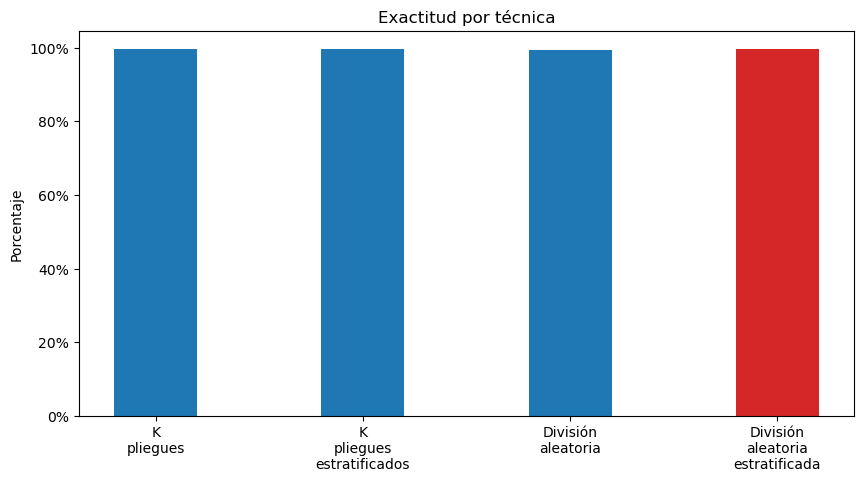

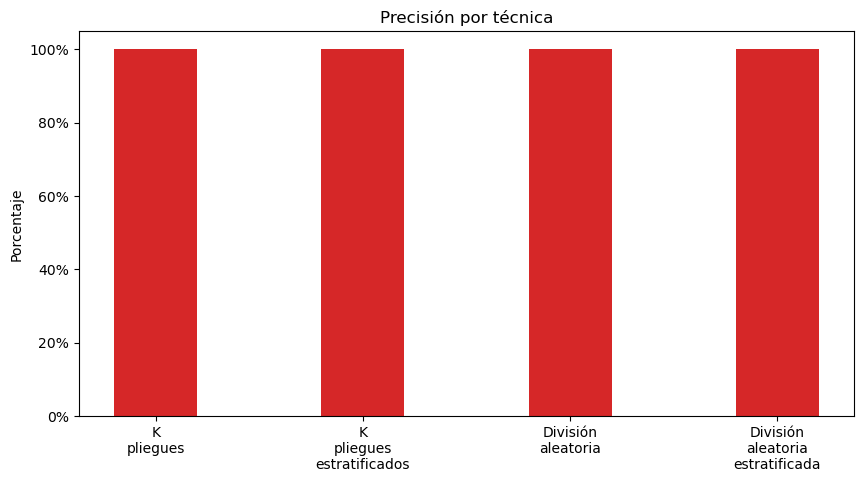

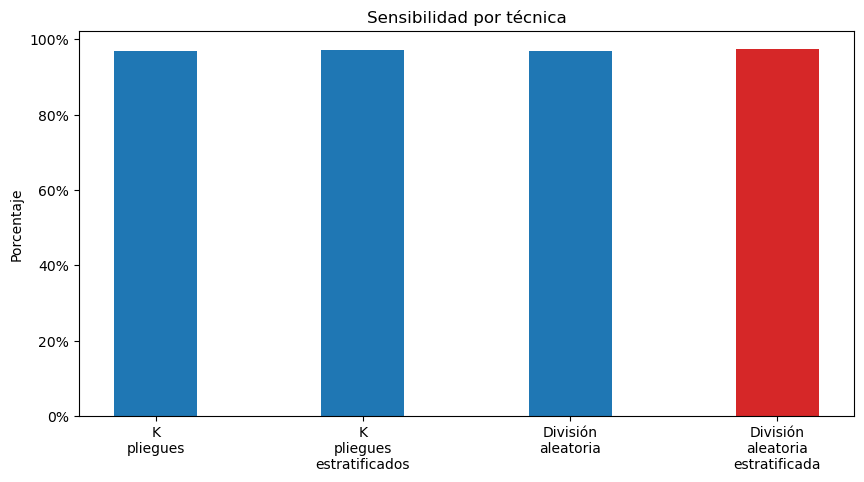

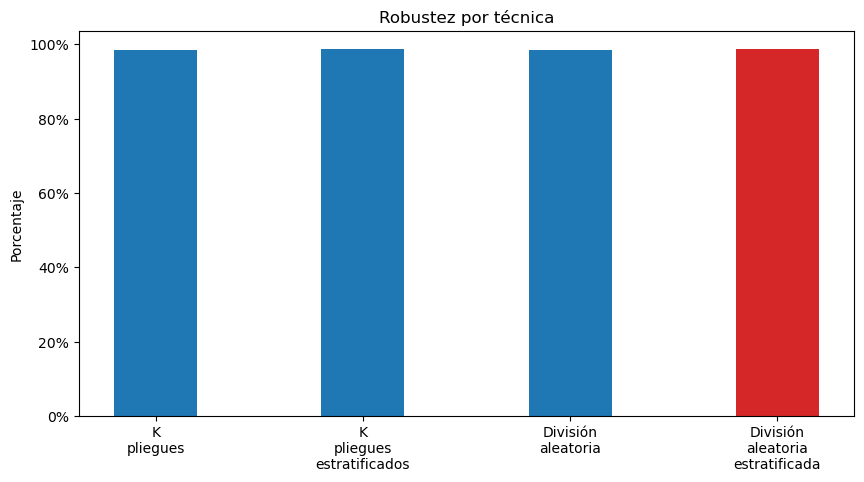

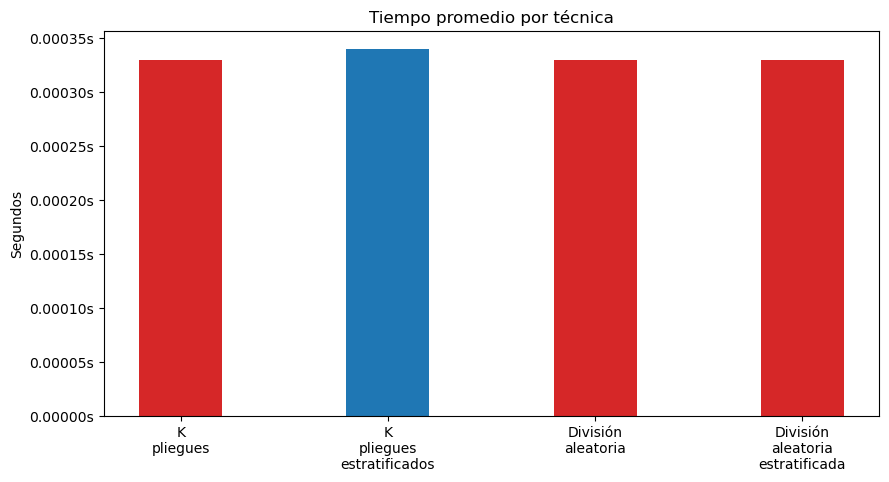

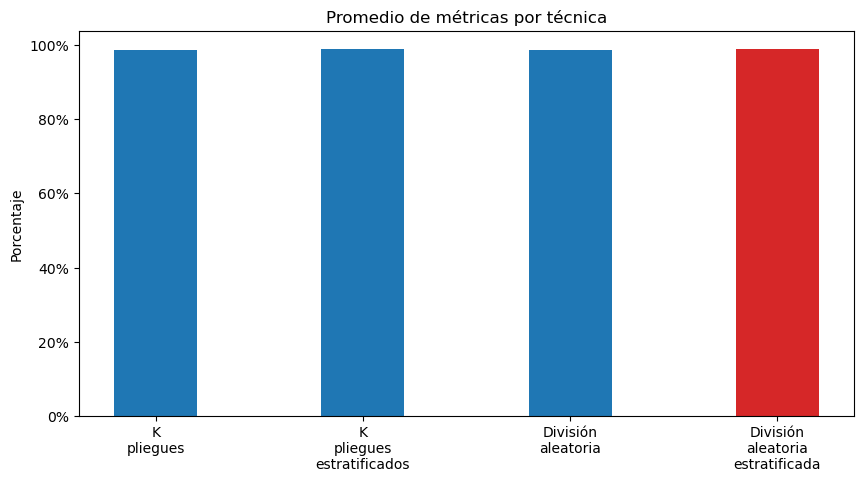

Técnica con mayor promedio de métricas: División aleatoria estratificada
Promedio de métricas: 98.90%
Exactitud: 99.56%
Precisión: 100.00%
Sensibilidad: 97.36%
Robustez: 98.66%
Tiempo total: 3.99305s
Tiempo promedio: 0.00033s

Partición con mayor promedio de métricas: Partición 3
Promedio de métricas: 99.06%
Exactitud: 99.63%
Precisión: 100.00%
Sensibilidad: 97.76%
Robustez: 98.87%
Tiempo total: 4.00292s
Tiempo promedio: 0.00033s

Fin: 2023-06-26 14:52:55.414947
Tiempo: 0:01:22.689730


In [117]:
if __name__ == "__main__":
  main()